In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os
print(os.listdir("./input"))

['.ipynb_checkpoints', 'sampleSubmission.csv', 'test1', 'train', 'Untitled.ipynb']


In [35]:
import zipfile
    	
fantasy_zip = zipfile.ZipFile('./input/train/train.zip')
fantasy_zip.extractall('./input/train/')

fantasy_zip.close()

In [17]:
import zipfile
    	
fantasy_zip = zipfile.ZipFile('./input/test1/test1.zip')
fantasy_zip.extractall('./input/test1/')

fantasy_zip.close()

In [12]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [15]:
filenames = os.listdir("./input/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [16]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


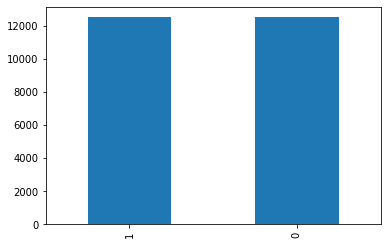

In [18]:
df['category'].value_counts().plot.bar()

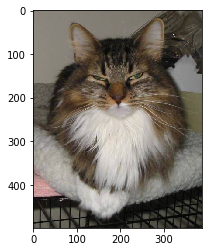

In [19]:
sample = random.choice(filenames)
image = load_img("./input/train/train/"+sample)
plt.imshow(image)

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
earlystop = EarlyStopping(patience=10)

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
callbacks = [earlystop, learning_rate_reduction]

In [25]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [26]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

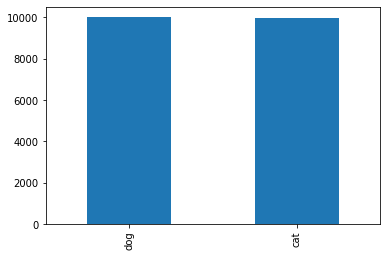

In [27]:
train_df['category'].value_counts().plot.bar()

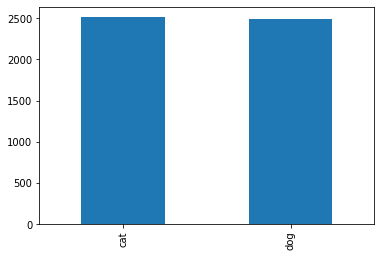

In [28]:
validate_df['category'].value_counts().plot.bar()

In [29]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [32]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [33]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


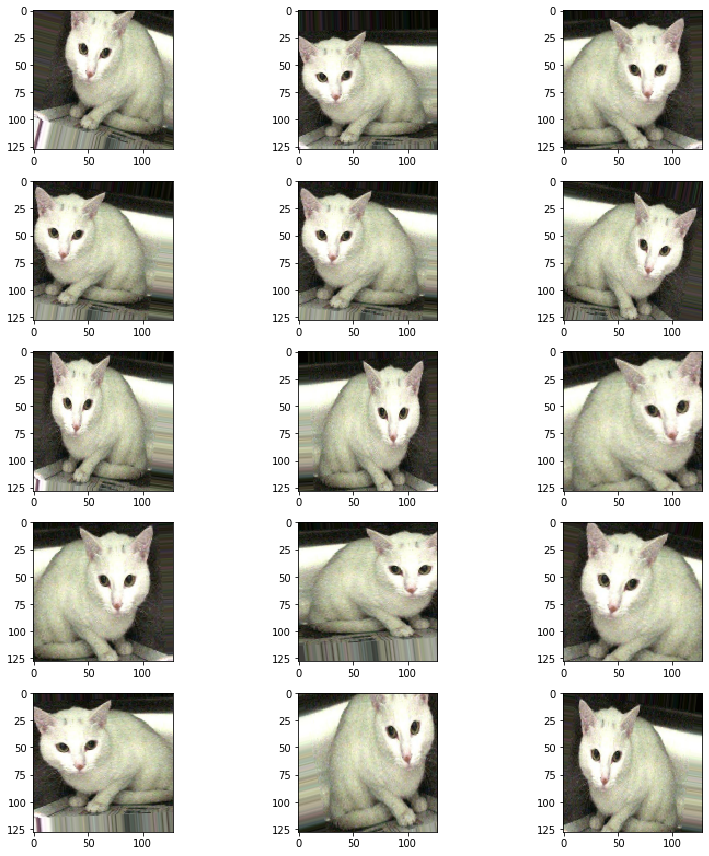

In [34]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [35]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1333/1333 [==============================] - 1104s 828ms/step - loss: 0.7505 - accuracy: 0.6434 - val_loss: 0.5491 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 1072s 804ms/step - loss: 0.5520 - accuracy: 0.7258 - val_loss: 0.5088 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 1017s 763ms/step - loss: 0.5041 - accuracy: 0.7613 - val_loss: 0.5256 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - 1067s 800ms/step - loss: 0.4700 - accuracy: 0.7821 - val_loss: 0.4705 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 1069s 802ms/step - loss: 0.4377 - accuracy: 0.8015 - val_loss: 0.4235 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - 25247s 19s/step - loss: 0.4134 - accuracy: 0.8164 - val_lo

1333/1333 [==============================] - 974s 731ms/step - loss: 0.3113 - accuracy: 0.8683 - val_loss: 0.3945 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 21/50
1333/1333 [==============================] - 971s 728ms/step - loss: 0.3059 - accuracy: 0.8699 - val_loss: 0.4429 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 22/50
1333/1333 [==============================] - 972s 729ms/step - loss: 0.3029 - accuracy: 0.8721 - val_loss: 0.3179 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 23/50
1333/1333 [==============================] - 968s 726ms/step - loss: 0.3064 - accuracy: 0.8684 - val_loss: 0.4668 - val_accuracy: 0.7752 - lr: 0.0010
Epoch 24/50
1333/1333 [==============================] - 975s 731ms/step - loss: 0.2950 - accuracy: 0.8742 - val_loss: 0.3076 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 25/50
1333/1333 [==============================] - 969s 727ms/step - loss: 0.2912 - accuracy: 0.8799 - val_loss: 0.2770 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 26/50
1333/1333 [=================

In [36]:
model.save_weights("model.h5")

In [41]:
print (history.history)

{'loss': [0.7505015134811401, 0.5519760251045227, 0.5040633678436279, 0.4700491726398468, 0.4376853406429291, 0.4134191870689392, 0.3984631896018982, 0.38487154245376587, 0.37097495794296265, 0.3676663935184479, 0.36043980717658997, 0.3468616306781769, 0.34334179759025574, 0.33650049567222595, 0.32760968804359436, 0.3297908306121826, 0.3193904161453247, 0.3146940767765045, 0.31880617141723633, 0.31130293011665344, 0.3058885335922241, 0.30290019512176514, 0.30636054277420044, 0.2950029671192169, 0.29124605655670166, 0.2919297516345978, 0.2892233729362488, 0.29107925295829773, 0.2830401062965393], 'accuracy': [0.6434325575828552, 0.7258443832397461, 0.7612709403038025, 0.7821366190910339, 0.8015011548995972, 0.8164123296737671, 0.8238178491592407, 0.8310732841491699, 0.8340755701065063, 0.8424318432807922, 0.8451839089393616, 0.8488866686820984, 0.8538904190063477, 0.8562421798706055, 0.8602451682090759, 0.860495388507843, 0.8645984530448914, 0.8659995198249817, 0.8622967004776001, 0.868

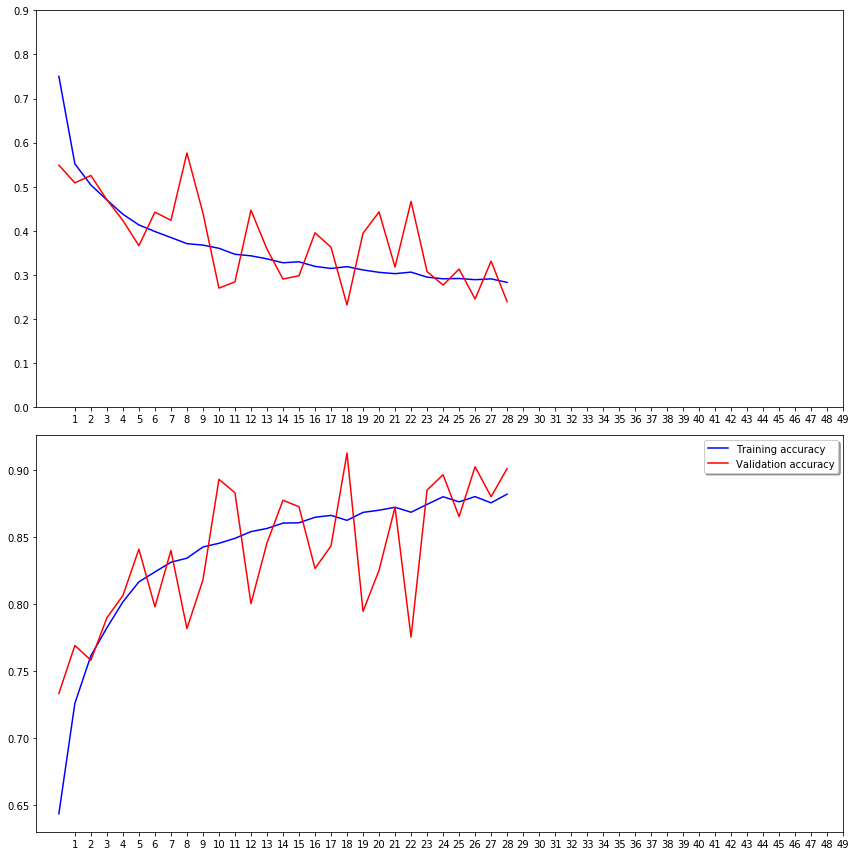

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [43]:
test_filenames = os.listdir("./input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [44]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [48]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [49]:
test_df['category'] = np.argmax(predict, axis=-1)

In [50]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [51]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

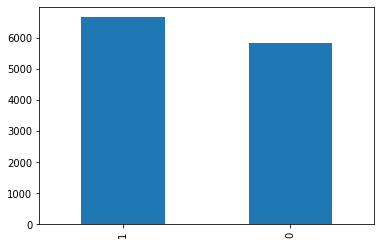

In [52]:
test_df['category'].value_counts().plot.bar()

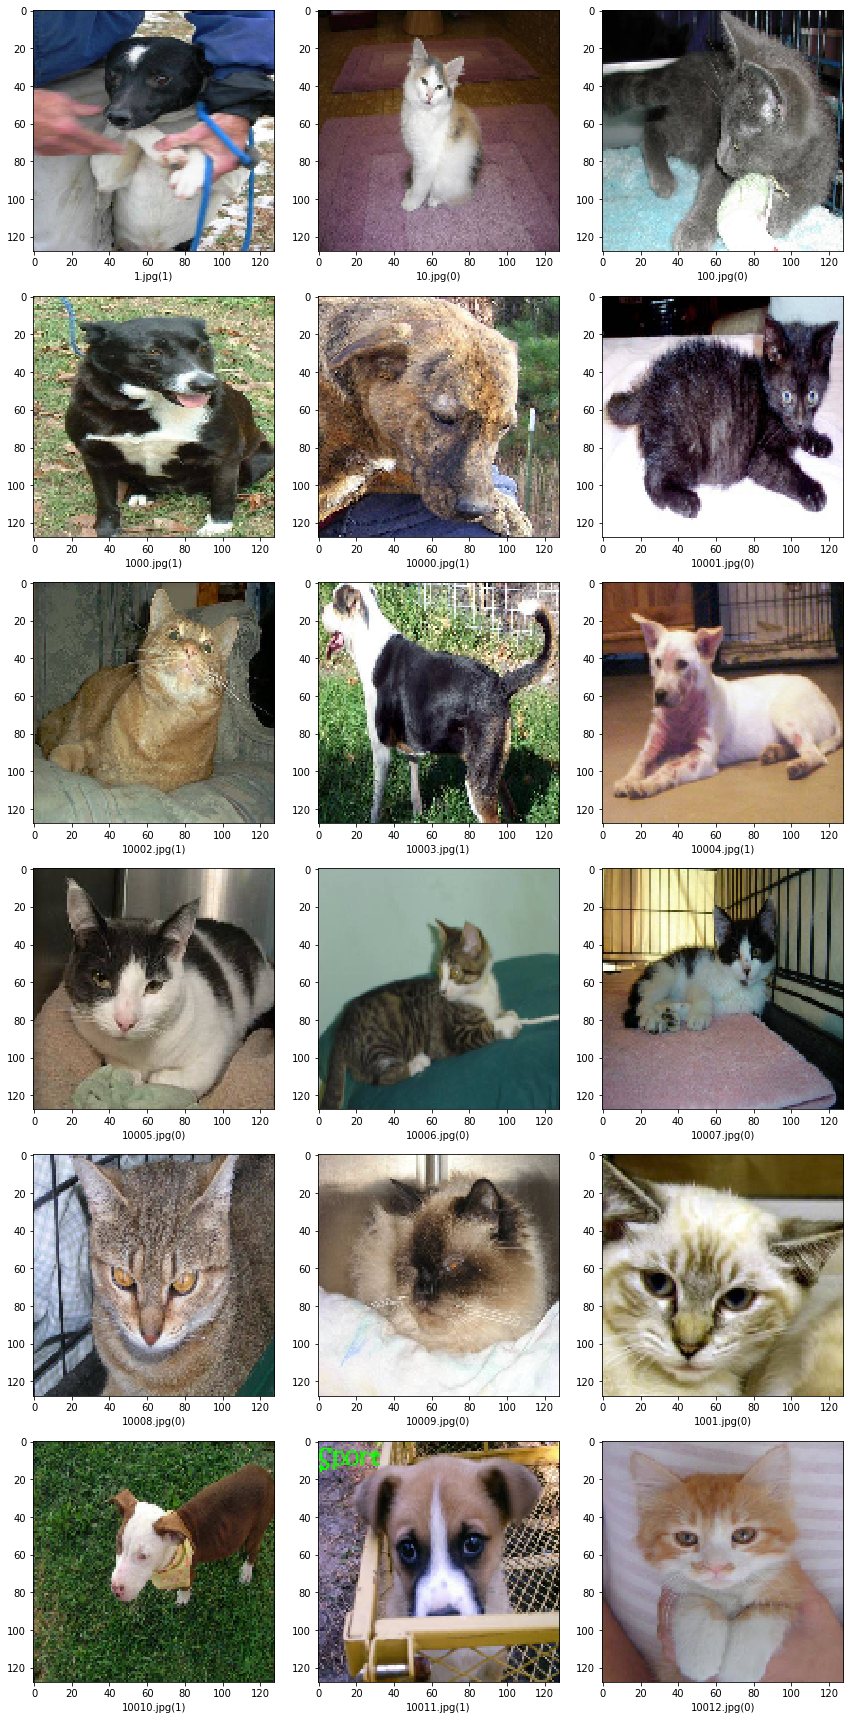

In [53]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [54]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission33.csv', index=False)